## Libraries Used

In [51]:
# Data Handling
import pandas as pd
import numpy as np
from collections import Counter # import Counter to count word frequencies

# Text Processing
import string
from wordcloud import STOPWORDS
import nltk
from nltk.corpus import stopwords, words
import contractions
from textblob import TextBlob, download_corpora
from spellchecker import SpellChecker
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import joblib

# Model Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


# Display Formatting
import IPython.display as display

# NLTK & TextBlob Downloads
download_corpora.download_all() 
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')  

[nltk_data] Downloading package brown to /Users/mohammad/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/mohammad/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mohammad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/mohammad/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/mohammad/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/mohammad/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package words to /Users/mohammad/nltk_data...
[nltk_data]   Packa

True

## Dataset extraction and organization
### Load and combine all datasets

In [3]:
# Load datasets
dataset1 = pd.read_csv('data/amazon_cells_labelled.txt', delimiter='\t', header=None, names=['Review', 'Sentiment'])
dataset2 = pd.read_csv('data/imdb_labelled.txt', delimiter='\t', header=None, names=['Review', 'Sentiment'])
dataset3 = pd.read_csv('data/yelp_labelled.txt', delimiter='\t', header=None, names=['Review', 'Sentiment'])

# Combine datasets
combined_dataset = pd.concat([dataset1, dataset2, dataset3], ignore_index=True)

# Ensure correct column ordering
combined_dataset = combined_dataset[['Review', 'Sentiment']]

# Convert Sentiment column to a centered string format 
combined_dataset["Sentiment"] = combined_dataset["Sentiment"].astype(str).apply(lambda x: f"{x:^5}")

# Display first 10 rows
display(combined_dataset.head(10)) 


,Review,Sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
5,I have to jiggle the plug to get it to line up...,0
6,If you have several dozen or several hundred c...,0
7,If you are Razr owner...you must have this!,1
8,"Needless to say, I wasted my money.",0
9,What a waste of money and time!.,0


## Data Cleaning and Preparation




In [4]:
# Load and basic cleaning
combined_dataset = combined_dataset.drop_duplicates(subset=['Review'])  # Removing duplicates
print("How many null our dataset has?", combined_dataset.isnull().sum().to_string())  # Checking for missing values
combined_dataset['Review'] = combined_dataset['Review'].str.lower()  # Converting to lowercase



# Tokenization (Returns List)
def tokenize_text(text):
    if isinstance(text, str):
        return re.findall(r'\b\w+\b', text.lower())  # regex for more precise tokenization
    return text

combined_dataset["Tokenized_Review"] = combined_dataset["Review"].apply(tokenize_text)


# Normalize Contractions
def normalize_contractions(tokens):
    if isinstance(tokens, list):
        return [contractions.fix(token) for token in tokens]
    return tokens

combined_dataset['Tokenized_Review'] = combined_dataset['Tokenized_Review'].apply(normalize_contractions)


# remove Punctuation, special Characters, and numbers in one place, better and faster than multiple filters. also removes single characters and non-alphabetic characters
# multiple filters for each step is going to slow down the process by way more (before: 5mins 30sec, after: 2min 4sec)
def clean_tokens(tokens):
    if isinstance(tokens, list):
        return [token for token in tokens if token.isalpha() and len(token) > 1] 
    return tokens

combined_dataset['Tokenized_Review'] = combined_dataset['Tokenized_Review'].apply(clean_tokens)


# Remove Stopwords
important_words = {
    "not", "no", "never", "none", "nobody", "nothing", "neither", "nowhere",
    "isn’t", "wasn’t", "aren’t", "weren’t", "doesn’t", "didn’t", "hasn’t", 
    "hadn’t", "won’t", "wouldn’t", "can’t", "couldn’t", "shouldn’t", "mustn’t"
}

stopwords = set(STOPWORDS) - important_words

def remove_stopwords(tokens): # remove stopwords
    if isinstance(tokens, list):
        return [token for token in tokens if token not in stopwords]
    return tokens

combined_dataset["Tokenized_Review"] = combined_dataset["Tokenized_Review"].apply(remove_stopwords)


# Faster Spell Correction
spell = SpellChecker()
nltk_words_set = set(words.words())  # load known words from NLTK, and spell check those against ours, another reason for slow process.

def correct_spelling(tokens):
    if isinstance(tokens, list):
        return [word if word in nltk_words_set else spell.correction(word) or word for word in tokens]
    return tokens

combined_dataset["Tokenized_Review"] = combined_dataset["Tokenized_Review"].apply(correct_spelling)


# Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_text(tokens):
    if isinstance(tokens, list):
        return [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

combined_dataset['Tokenized_Review'] = combined_dataset['Tokenized_Review'].apply(lemmatize_text)


# Convert cleaned token list back into sentences
combined_dataset['Review'] = combined_dataset['Tokenized_Review'].apply(lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else tokens)
combined_dataset['Review'].head()


How many null our dataset has? Review       0
Sentiment    0


0                    no way plug u unless go converter
1                            good case excellent value
2                                        great jawbone
3    tied charger conversation lasting minute major...
4                                            mic great
Name: Review, dtype: object

## Exploratory Data Analysis
### Visualizing and analyzing sentiment distribution.

### Use bar charts 
>to show positive vs. negative sentiments.

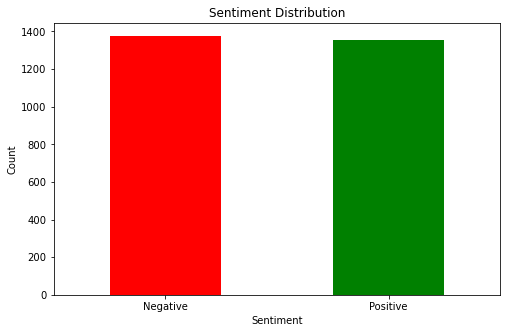

In [5]:
# Count sentiment occurrences
sentiment_counts = combined_dataset['Sentiment'].value_counts()

# Plot the sentiment distribution
sentiment_counts.plot(kind="bar", color=["red", "green"], figsize=(8,5))

# Set labels
plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"], rotation=0)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution")

# Show plot
plt.show()

### Distribution of review lengths
>Histogram showing text lenght distribution

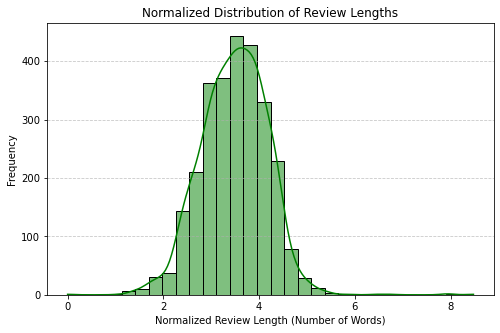

In [6]:
# Apply log transformation to normalize review length distribution
Normalized_Review_Length = np.log1p(combined_dataset["Review"].apply(len))  # log1p avoids log(0) error

# Plot histogram of log-transformed review lengths
plt.figure(figsize=(8, 5))
sns.histplot(Normalized_Review_Length, bins=30, kde=True, color="green", edgecolor="black")
plt.xlabel("Normalized Review Length (Number of Words)")
plt.ylabel("Frequency")
plt.title("Normalized Distribution of Review Lengths")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


### Word Cloud for Most Frequent Word
>Generating word clouds for both positive and negative sentiments

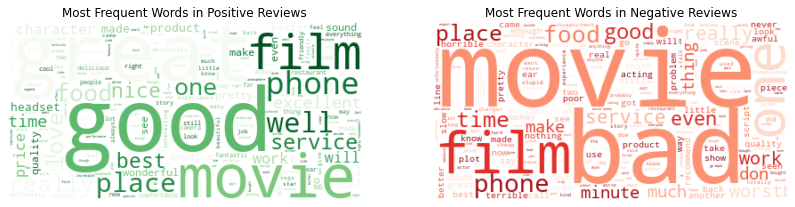

In [7]:
# Create WordCloud objects without stopwords
wc_positive = WordCloud(background_color="white", max_words=200, colormap="Greens")
wc_negative = WordCloud(background_color="white", max_words=200, colormap="Reds")

# Ensure Sentiment column is properly formatted
combined_dataset["Sentiment"] = combined_dataset["Sentiment"].astype(str).str.strip()

# Generate word clouds
positive_reviews = ' '.join(combined_dataset[combined_dataset["Sentiment"] == "1"]["Review"].tolist())  
negative_reviews = ' '.join(combined_dataset[combined_dataset["Sentiment"] == "0"]["Review"].tolist())  

positive_wc = wc_positive.generate(positive_reviews)
negative_wc = wc_negative.generate(negative_reviews)

# Plot word clouds
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Positive Reviews")

plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Negative Reviews")

plt.show()


### Term Frequency Analysis
>Identifing most common words in positive and negative reviews.

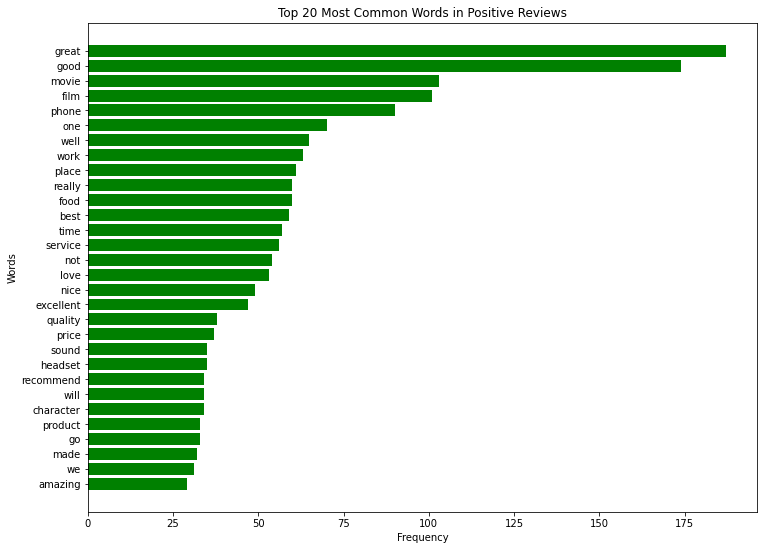

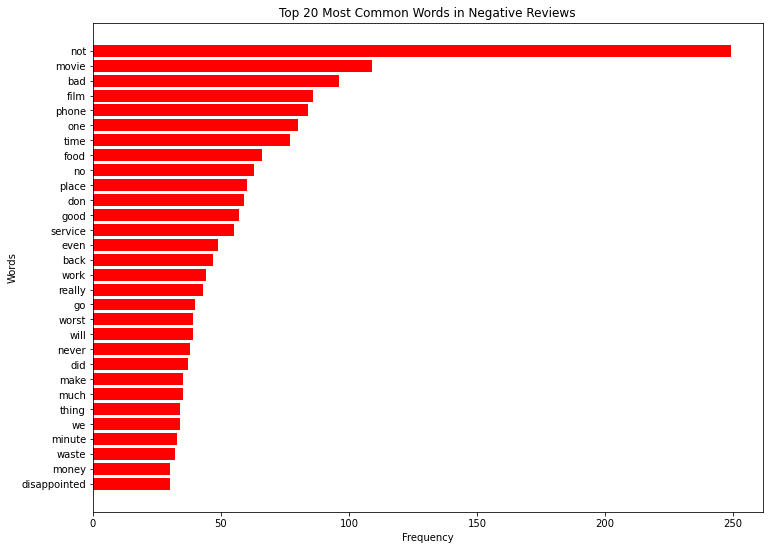

In [8]:
combined_dataset['Review'] = combined_dataset['Review']

# Tokenize words from positive and negative reviews 
positive_words = ' '.join(combined_dataset[combined_dataset['Sentiment'].str.strip() == '1']['Review']).split() # get postive reviews from dataset using the 1 indicator
negative_words = ' '.join(combined_dataset[combined_dataset['Sentiment'].str.strip() == '0']['Review']).split() # get negative reviews from dataset using the 0 indicator


positive_word_freq = Counter(positive_words) # count positive words 
negative_word_freq = Counter(negative_words) # count negative words
top_positive_words = positive_word_freq.most_common(30) # get the top 30 most used words in positive reviews
top_negative_words = negative_word_freq.most_common(30) # get the top 30 most used words in negative reviews

df_positive = pd.DataFrame(top_positive_words, columns=['Word', 'Frequency']) # DF for positive words
df_negative = pd.DataFrame(top_negative_words, columns=['Word', 'Frequency']) # DF for negative words

# plotting
plt.figure(figsize=(12, 9))
plt.barh(df_positive['Word'], df_positive['Frequency'], color='green')
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Common Words in Positive Reviews")
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(12, 9))
plt.barh(df_negative['Word'], df_negative['Frequency'], color='red')
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Common Words in Negative Reviews")
plt.gca().invert_yaxis()
plt.show()

## Model Selection


 ### Vader
 >Leveraging a rule-based model to assess sentiment.

#### Vader implementation

In [9]:

#  Convert sentiment to categorical labels (0 = Negative, 1 = Positive)
combined_dataset['Sentiment'] = combined_dataset['Sentiment'].astype(int)

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply VADER to each review and get compound score
combined_dataset['VADER_compound'] = combined_dataset['Review'].apply(lambda review: analyzer.polarity_scores(review)['compound']) #  or Review 

# Convert VADER scores into binary sentiment labels
combined_dataset["VADER_Prediction"] = combined_dataset["VADER_compound"].apply(lambda score: 1 if score >= 0.05 else 0)


# Test with a Custom Sentence
def predict_sentiment_vader(text):
    score = analyzer.polarity_scores(text)['compound']
    sentiment = "Positive" if score >= 0.05 else "Negative"
    return sentiment, score

dummy_reviews= [
    "This product is really cool",
    "This movie sucked",
    "I hate this",
    "Had a really good time",
    "My son and I thought it was just okay",
    "Where can I see more of this?"
]

for review in dummy_reviews:
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {predict_sentiment_vader(review)[0]}")
    print(f"Sentiment Score: {predict_sentiment_vader(review)[1]:.2f}\n")


Review: This product is really cool
Predicted Sentiment: Positive
Sentiment Score: 0.38

Review: This movie sucked
Predicted Sentiment: Negative
Sentiment Score: -0.46

Review: I hate this
Predicted Sentiment: Negative
Sentiment Score: -0.57

Review: Had a really good time
Predicted Sentiment: Positive
Sentiment Score: 0.49

Review: My son and I thought it was just okay
Predicted Sentiment: Positive
Sentiment Score: 0.23

Review: Where can I see more of this?
Predicted Sentiment: Negative
Sentiment Score: 0.00



### Logisitic Regression 
>Training a supervised learning model for sentiment classification

In [23]:
combined_dataset['Review'] # reviews from dataset


vectorizer = TfidfVectorizer(max_features=10000) # turn text into numbers and keep top 10k words
x = vectorizer.fit_transform(combined_dataset['Review']) # create TF-IDF matrix, which is a matrix that measuires the importance of each word
y = combined_dataset['Sentiment'] # target variable (0 = negative, 1 = positive)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) # splitting data into training sets (80%) and testing sets (20%) 


model = LogisticRegression() # initialize Logistic Regression model from scikit-learn
model.fit(x_train, y_train) # train model on training sets by initializing weights and biases and then optimizing them by minimizing the loss function which is how wrong the model is
y_pred = model.predict(x_test) # from the trained model, predict the sentiment of the test set
accuracy = accuracy_score(y_test, y_pred) # calculate accuracy
accuracy = accuracy*100 # convert to percentage
print(f"Accuracy: {accuracy:.2f}%")


def predict_sentiment(text): # creating function to predict sentiment (0 = negative, 1 = positive) on some dummy data
    vectorized_text = vectorizer.transform([text])
    sentiment = model.predict(vectorized_text)[0]
    return sentiment

def sentiment_score(text): # creating function to see exactly how positive or negative a review is 
    vectorized_text = vectorizer.transform([text])
    sentiment_score = model.decision_function(vectorized_text)[0]
    return sentiment_score

dummy_reviews= [
    "This product is really cool",
    "This movie sucked",
    "I hate this",
    "Had a really good time",
    "My son and I thought it was just okay",
    "Where can I see more of this?"
]

for review in dummy_reviews:
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {predict_sentiment(review)}")
    print(f"Sentiment Score: {sentiment_score(review):.2f}\n")



joblib.dump(model, "logistic_regression.pkl") # to save the model
joblib.dump(vectorizer, "tfidf_vectorizer.pkl") # to save the vectorizer


Accuracy: 80.62%
Review: This product is really cool
Predicted Sentiment: 1
Sentiment Score: 1.00

Review: This movie sucked
Predicted Sentiment: 0
Sentiment Score: -0.54

Review: I hate this
Predicted Sentiment: 0
Sentiment Score: -0.92

Review: Had a really good time
Predicted Sentiment: 1
Sentiment Score: 1.23

Review: My son and I thought it was just okay
Predicted Sentiment: 0
Sentiment Score: -0.05

Review: Where can I see more of this?
Predicted Sentiment: 1
Sentiment Score: 0.21



['tfidf_vectorizer.pkl']

## Model Analysis

### Classifcation Report
>provides a detailed performance summary of a classification model. It includes key metrics such as precision, recall, F1-score, and support for each class.

#### Vader

#### Logisitic Regression

In [11]:
y_pred = model.predict(x_test) # generate prediction for test set trained on LR model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       270
           1       0.80      0.82      0.81       277

    accuracy                           0.81       547
   macro avg       0.81      0.81      0.81       547
weighted avg       0.81      0.81      0.81       547



### Confusion Matrix
>Essential for analyzing false positives and false negatives.

#### VADER  

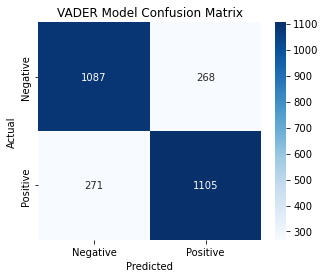

In [12]:
# plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(combined_dataset['Sentiment'], combined_dataset["VADER_Prediction"]), annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("VADER Model Confusion Matrix")
plt.show()


#### Logisitic Regression

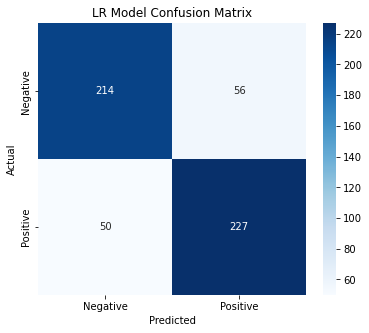

In [13]:
y_pred = model.predict(x_test) # prediction for test set trained on LR model 
cm = confusion_matrix(y_test, y_pred) # confusion matrix for test set trained on LR model

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"], fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("LR Model Confusion Matrix")
plt.show()

### Threshold-Based Accuracy
>Measures how often model sentiment matches labels.

#### Vader

In [14]:
#  Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

#  Apply VADER to each review and get the compound score
combined_dataset['VADER_Compound'] = combined_dataset['Review'].apply(lambda review: analyzer.polarity_scores(review)['compound'])

#  Convert VADER scores into binary sentiment labels (Threshold-Based)
combined_dataset["VADER_Prediction"] = combined_dataset["VADER_Compound"].apply(lambda score: 1 if score >= 0.05 else 0)

#  Compute Threshold-Based Accuracy
accuracy = accuracy_score(combined_dataset['Sentiment'], combined_dataset['VADER_Prediction'])

#  Print Accuracy Result
print(f"VADER Threshold-Based Accuracy: {accuracy:.2%}")


VADER Threshold-Based Accuracy: 80.26%


#### Logisitic Regression

In [15]:
# predict using the LR model we trained
combined_dataset['Logisitic_Regression_Prediction'] = model.predict(vectorizer.transform(combined_dataset['Review'])) 

# use accuracy_score from sklearn to calculate accuracy of LR model by using data that was predicted witht the model above
accuracy = accuracy_score(combined_dataset['Sentiment'], combined_dataset['Logisitic_Regression_Prediction'])

print(f"Logistic Regression Threshold-Based Accuracy: {accuracy:.2%}")

Logistic Regression Threshold-Based Accuracy: 92.46%


### Mean Squared Error (MSE) 
>Measures how close model's scores are to actual sentiment.

#### Vader

In [16]:
import numpy as np

# Compute MSE manually using NumPy
mse = np.mean((combined_dataset['Sentiment'] - combined_dataset['VADER_Compound']) ** 2)

print(f"VADER Mean Squared Error (MSE): {mse:.4f}")


VADER Mean Squared Error (MSE): 0.2858


#### Logisitic Regression

In [17]:
mse = np.mean((combined_dataset['Sentiment'] - combined_dataset['Logisitic_Regression_Prediction']) ** 2) # MSE calculation

print(f"Logistic Regression Mean Squared Error (MSE): {mse:.4f}")

Logistic Regression Mean Squared Error (MSE): 0.0754


### Spearman/Pearson Correlation 
>Measures how well model scores align with actual sentiment.


#### Vader

In [18]:
# Pearson correlation (linear relationship)
pearson_corr = combined_dataset['Sentiment'].corr(combined_dataset['VADER_Compound'], method='pearson')

# Spearman correlation (rank-based, monotonic relationship)
spearman_corr = combined_dataset['Sentiment'].corr(combined_dataset['VADER_Compound'], method='spearman')

print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}")


Pearson Correlation: 0.6606
Spearman Correlation: 0.6626


### Logistic Regression

In [19]:
# to measure linear relationship between prediction of sentiment and actual sentiment
pearson_corr = combined_dataset['Sentiment'].corr(combined_dataset['Logisitic_Regression_Prediction'], method='pearson')
# to measure how well the order of predictions matches the order of actual sentiment
spearman_corr = combined_dataset['Sentiment'].corr(combined_dataset['Logisitic_Regression_Prediction'], method='spearman')

print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}")

Pearson Correlation: 0.8493
Spearman Correlation: 0.8493


### ROC Curve & AUC
>Measures classification performance across thresholds.

#### Vader

#### Logisitic Regression

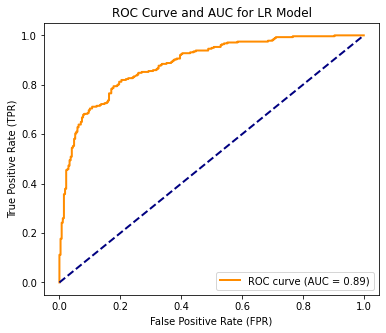

In [20]:
# predict probability of positive sentiment class
y_probability = model.predict_proba(x_test)[:,1] 
 # calculate negative sentiments that are labled as positive by the model, and calculate positive sentiments that are accurately predicted, both at different thresholds, AKA FPR and TPR and then place them on the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probability)
# get the score of how accurate the model is AKA area under the curve
roc_auc = roc_auc_score(y_test, y_probability)

# plot ROC curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)') # 
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve and AUC for LR Model') 
plt.legend(loc="lower right")
plt.show()

## Vader vs Logistic Regression Results and Real-Life application experiment

### Results Comparsion

#### Vader

### **IN REPORT**

#### Logisitic Regression

### **IN REPORT**

### Real-Life application
>Say what expierment we're doing and compare at the end 

## Dataset Cleaning

#### While Vader doesn't need the dataset to be cleaned since it works with raw text, we still need to do it for Logisitic Regression since we trained the model on preprocessed data. 

In [21]:
tweet_dataset = pd.read_csv('data/tweets.csv') # get tweet dataset
text_column = 'Text' # get only text since we do not care for users or anything else 
tweet_dataset = tweet_dataset[[text_column]].dropna() # keep the text and drop any values that are NaN


def preprocess_text(text): # some light cleaning 
    text = text.lower()  
    text = ''.join([c for c in text if c.isalnum() or c.isspace()])
    return text

tweet_dataset['tweets'] = tweet_dataset[text_column].apply(preprocess_text)

print(tweet_dataset['tweets'].head())

0    is upset that he cant update his facebook by t...
1    kenichan i dived many times for the ball manag...
2      my whole body feels itchy and like its on fire 
3    nationwideclass no its not behaving at all im ...
4                         kwesidei not the whole crew 
Name: tweets, dtype: object


#### Vader

In [28]:
analyzer = SentimentIntensityAnalyzer()

tweet_dataset['VADER_compound'] = tweet_dataset['tweets'].apply(lambda text: analyzer.polarity_scores(text)['compound']) # get sentiment scores for vader
tweet_dataset['VADER_Prediction'] = tweet_dataset['VADER_compound'].apply(lambda score: 1 if score >= 0.05 else 0) # label sentences with positive or negative

print(tweet_dataset[['tweets', 'VADER_compound', 'VADER_Prediction']].head()) # get first 5 rows of labeled and scored sentences

                                              tweets  VADER_compound  \
0  is upset that he cant update his facebook by t...         -0.7269   
1  kenichan i dived many times for the ball manag...          0.4939   
2    my whole body feels itchy and like its on fire          -0.2500   
3  nationwideclass no its not behaving at all im ...         -0.6597   
4                       kwesidei not the whole crew           0.0000   

   VADER_Prediction  
0                 0  
1                 1  
2                 0  
3                 0  
4                 0  


#### Logisitic Regression

In [31]:
model = joblib.load("logistic_regression.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

vectorized_tweets = vectorizer.transform(tweet_dataset['tweets']) # put tweets into vectorizer so its numerical
tweet_dataset['LR_Score'] = model.decision_function(vectorized_tweets) # Get sentiment scores for LR
tweet_dataset['LR_Prediction'] = model.predict(vectorized_tweets) # label sentence with positive or negative

print(tweet_dataset[['tweets', 'LR_Score', 'LR_Prediction']].head()) # get first 5 rows of labeled and scored sentences

                                              tweets  LR_Score  LR_Prediction
0  is upset that he cant update his facebook by t... -0.489636              0
1  kenichan i dived many times for the ball manag... -0.175660              0
2    my whole body feels itchy and like its on fire   0.227886              1
3  nationwideclass no its not behaving at all im ... -0.998843              0
4                       kwesidei not the whole crew  -1.485125              0


### Visualizing Results

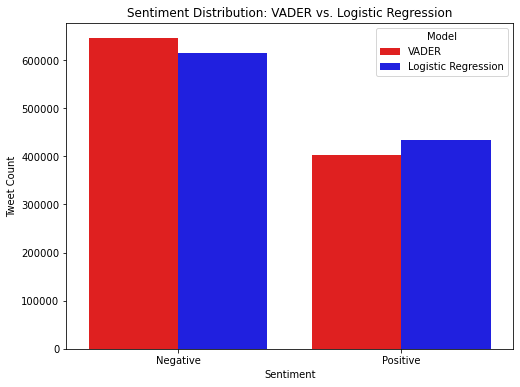

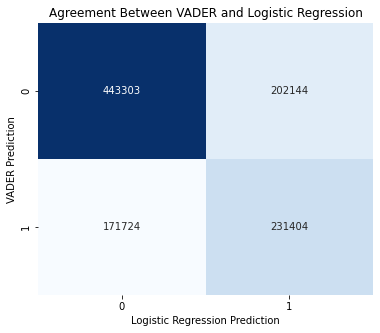

In [40]:
# Sentiment Distribution 
plt.figure(figsize=(8,6))
sns.countplot(x='Sentiment', 
              data=tweet_dataset.melt(id_vars=['tweets'], 
              value_vars=['VADER_Prediction', 'LR_Prediction'],
              var_name='Model', 
              value_name='Sentiment'),
              hue='Model', palette={"VADER_Prediction": "red", "LR_Prediction": "blue"})
plt.xticks([0,1], ['Negative', 'Positive'])
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")
plt.title("Sentiment Distribution: VADER vs. Logistic Regression")
plt.legend(title="Model", labels=["VADER", "Logistic Regression"])
plt.show()


# Heatmap of Agreement
plt.figure(figsize=(6,5))
agreement_matrix = pd.crosstab(tweet_dataset['VADER_Prediction'], tweet_dataset['LR_Prediction'])
sns.heatmap(agreement_matrix, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.xlabel("Logistic Regression Prediction")
plt.ylabel("VADER Prediction")
plt.title("Agreement Between VADER and Logistic Regression")
plt.show()

### Sample random tweets to compare

In [52]:
comparsion_examples = tweet_dataset.sample(10)[['tweets', 'VADER_Prediction', 'LR_Prediction', 'VADER_compound', 'LR_Score']] # compare some random samples between the two models


display.display(comparsion_examples)

,tweets,VADER_Prediction,LR_Prediction,VADER_compound,LR_Score
524665,is jus chillin listenin 2 sum musicits propaaa...,0,0,0.0000,-0.109257
170577,itchy boobs,0,0,-0.2732,-0.256562
340317,i lost my social network account grr,0,0,-0.3182,-0.469533
465286,manaloloandlola i knowww hahah yes but i cant ...,0,0,-0.3802,-0.189853
99116,bah so would like to be at futuresonic and be2...,1,0,0.4173,-0.120677
552967,tummyache but that milkshake was so delicious...,1,1,0.8683,1.502539
396985,taking meagan to the airport,0,1,0.0000,0.452162
51434,susanadrian sends back healing vibes,0,0,0.0000,-0.555935
426349,bright smiling suns shining through the window...,1,0,0.7960,-0.102458
860489,joleezy wish me luck,1,0,0.6908,-0.636744


### Disagreement visualizations

In [53]:
disagreement_equation = tweet_dataset[tweet_dataset['VADER_Prediction'] != tweet_dataset['LR_Prediction']][['tweets', 'VADER_Prediction', 'LR_Prediction', 'VADER_compound', 'LR_Score']] # tweets where the models disagree
compare_disagreements = disagreement_equation.sample(10) if len(disagreement_equation) > 10 else disagreement_equation # choose random 10 tweets

display.display(compare_disagreements)

,tweets,VADER_Prediction,LR_Prediction,VADER_compound,LR_Score
870005,rockminxdiva oh yeah remember petz amp babyz ...,1,0,0.1531,-0.161242
580830,billharper kahleerose thanks for the sympathy ...,1,0,0.1027,-0.159241
533618,need rum cant have,0,1,0.0000,0.020016
886109,goudystout i think im going to go to bed,0,1,0.0000,0.123425
720079,exactly i miss ian too kianasaurus,0,1,-0.1531,0.852142
175343,im not sure why walking around in barnes and n...,1,0,0.7581,-0.739554
633099,jnodding i dont like boxes,0,1,-0.2755,0.069285
763020,i just get used to paypals creative accounting...,1,0,0.4404,-0.064037
682730,i really want to feel better now i think me be...,0,1,0.0498,0.140082
842383,deewatawata i felt the same away after i saw h...,0,1,0.0000,0.082302


## IGNORE: compressing dataset to push to github

In [54]:
df = pd.read_csv("data/tweets.csv")

# Save as compressed ZIP
df.to_csv("data/tweets_compressed.zip", index=False, compression="zip")

print("Dataset compressed and saved as 'tweets_compressed.zip'")

Dataset compressed and saved as 'tweets_compressed.zip'
